<a href="https://colab.research.google.com/github/robLaing2/Forex_ANN_Forecasting/blob/master/ForexAnnEnvironment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setting up Environment

In [0]:
%tensorflow_version 2.x

!pip install quandl
!pip install dbnomics
#!pip uninstall tensorflow
#!pip install tensorflow==2.0.0

# Loading Data

In [0]:
import quandl
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense, Activation
from dbnomics import fetch_series
import pandas as pd

startDate = '2010-01-01'
endDate = '2019-01-01'

# Get FOREX data
quandl.ApiConfig.api_key = "VXqfuyrbTE8xxYZzqePw"
dataGbpEurRate = quandl.get("BOE/XUDLERS", start_date=startDate, end_date=endDate, returns="numpy")
forexDataN = dataGbpEurRate.Value

ukCPI = fetch_series('IMF/CPI/M.GB.PCPIHA_PC_CP_A_PT')
euCPI = fetch_series('IMF/CPI/M.U2.PCPIHA_PC_CP_A_PT')
ukIR = fetch_series('IMF/IFS/M.GB.RAFAGOLDM_USD')
euIR = fetch_series('IMF/IFS/M.U2.RAFAGOLDM_USD')
ukBOP = fetch_series('IMF/BOP/Q.GB.BACK_BP6_USD')
euBOP = fetch_series('IMF/BOP/Q.U2.BACK_BP6_USD')

dbnomicsQuery = "period >= '2010-01-01' and period < '2019-06-01'"

ukCPI = ukCPI.query(dbnomicsQuery)
euCPI = euCPI.query(dbnomicsQuery)
ukIR = ukIR.query(dbnomicsQuery)
euIR = euIR.query(dbnomicsQuery)
ukBOP = ukBOP.query(dbnomicsQuery)
euBOP = euBOP.query(dbnomicsQuery)

ukCPIarr = np.array(ukCPI.value, dtype=np.float)
euCPIarr = np.array(euCPI.value, dtype=np.float)
ukIRarr = np.array(ukIR.value, dtype=np.float)
euIRarr = np.array(euIR.value, dtype=np.float)
ukBOParr = np.array(ukBOP.value, dtype=np.float)
euBOParr = np.array(euBOP.value, dtype=np.float)

ukEuCpiRatio = ukCPIarr*1000 / euCPIarr*1000
ukEuIRRatio = ukIRarr*1000 / euIRarr*1000
ukEuBOPRatio = ukBOParr*1000 / euBOParr*1000

# Normalise data
forex_mean = forexDataN.mean()
forex_std = forexDataN.std()
forexDataN = (forexDataN - forex_mean) / forex_std

# Normalise CPI data
cpi_mean = ukEuCpiRatio.mean()
cpi_std = ukEuCpiRatio.std()
ukEuCpiRatio = (ukEuCpiRatio - cpi_mean) / cpi_std

# Normalise IR data
ir_mean = ukEuIRRatio.mean()
ir_std = ukEuIRRatio.std()
ukEuIRRatio = (ukEuIRRatio - ir_mean) / ir_std

# Normalise BOP data
bop_mean = ukEuBOPRatio.mean()
bop_std = ukEuBOPRatio.std()
ukEuBOPRatio = (ukEuBOPRatio - bop_mean) / bop_std

forexData = {'Date':dataGbpEurRate.Date,'Value':forexDataN}
forexDf =pd.DataFrame(forexData)

cpiData = {'Date':ukCPI.period, 'Value':ukEuCpiRatio}
cpiDf = pd.DataFrame(cpiData)

irData = {'Date':ukIR.period, 'Value':ukEuIRRatio}
irDf = pd.DataFrame(irData)

mainDf = pd.DataFrame(columns=['Date','ForexRateNorm','CPIRatioNorm', 'IRRatioNorm'])

cpiCounter = 0
irCounter = 0

for index, row in forexDf.iterrows():
    year = row['Date'].year
    month = row['Date'].month

    currentCPI = cpiDf.iloc[cpiCounter]['Date']
    cpiYear = currentCPI.year
    cpiMonth = currentCPI.month

    while(year != cpiYear or month != cpiMonth):
        cpiCounter = cpiCounter + 1
        currentCPI = cpiDf.iloc[cpiCounter]['Date']
        cpiYear = currentCPI.year
        cpiMonth = currentCPI.month

    currentIr = irDf.iloc[irCounter]['Date']
    irYear = currentIr.year
    irMonth = currentIr.month

    while(year != irYear or month != irMonth):
        irCounter = irCounter + 1
        currentCPI = cpiDf.iloc[irCounter]['Date']
        irYear = currentCPI.year
        irMonth = currentCPI.month

    mainDf = mainDf.append({'Date':row['Date'], 'ForexRateNorm':row['Value'], 'CPIRatioNorm':cpiDf.iloc[cpiCounter]['Value'], 'IRRatioNorm':irDf.iloc[irCounter]['Value']}, ignore_index=True)

print(mainDf)




# Split and format data
futureDistance = 0
historySize = 6

           Date  ForexRateNorm  CPIRatioNorm  IRRatioNorm
0    2010-01-04      -1.114569      1.119048    -2.313027
1    2010-01-05      -1.171301      1.119048    -2.313027
2    2010-01-06      -1.172561      1.119048    -2.313027
3    2010-01-07      -1.167519      1.119048    -2.313027
4    2010-01-08      -1.146086      1.119048    -2.313027
...         ...            ...           ...          ...
2269 2018-12-24      -1.199037     -0.059608     1.580271
2270 2018-12-26      -1.199037     -0.059608     1.580271
2271 2018-12-27      -1.217947     -0.059608     1.580271
2272 2018-12-28      -1.205340     -0.059608     1.580271
2273 2018-12-31      -1.136001     -0.059608     1.580271

[2274 rows x 4 columns]


In [0]:
print(13418.275667 / 466266.96270)

0.028778096542159324


# Standard ANN Model

In [0]:
def formatData(data, start, end, history, target):
    x = []
    y = []
    
    startIndex = start + historySize
    endIndex = len(data) - futureDistance

    for i in range(startIndex, endIndex):
        indices = range(i-historySize, i)
        # Reshape data from (history_size,) to (history_size, 1)
        x.append(data[indices])
        y.append(data[i+futureDistance])
        
    return np.array(x), np.array(y)


TRAIN_SPLIT = round(len(forexData) * 0.7)
VALIDATION_SPLIT = round(len(forexData) * 0.85)

xTrain, yTrain = formatData(forexData, 0, TRAIN_SPLIT, historySize, futureDistance)
xVal, yVal = formatData(forexData, TRAIN_SPLIT, VALIDATION_SPLIT, historySize, futureDistance)
xTest, yTest = formatData(forexData, VALIDATION_SPLIT, None, historySize, futureDistance)

BATCH_SIZE = 30
BUFFER_SIZE = 10

# Form training tensors and shuffle etc.
dataTrain = tf.data.Dataset.from_tensor_slices((xTrain, yTrain))
dataTrain = dataTrain.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
# Form validation tensors and shuffle etc.
dataVal = tf.data.Dataset.from_tensor_slices((xVal, yVal))
dataVal = dataVal.batch(BATCH_SIZE).repeat()

# Create model
EVALUATION_INTERVAL = 200
EPOCHS = 100

def standard_ann_model():
	model = keras.Sequential([
        layers.Dense(6,input_dim=(6),kernel_initializer='normal',activation='relu'),
        layers.Dense(8, activation='relu'),
        layers.Dense(1)
    ])

	model.compile(optimizer='adam', loss='mse')
	return model

model = standard_ann_model()

model.fit(dataTrain, epochs=EPOCHS,
                     steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=dataVal,
                      validation_steps=50)


result = model.evaluate(xTest, yTest, batch_size=30)
print("-----------------------------------------")
print("Model loss:", result)

Train on 200 steps, validate on 50 steps
Epoch 1/100
200/200 [==============================] - 1s 3ms/step - loss: 0.7567 - val_loss: 0.4809
Epoch 2/100
200/200 [==============================] - 0s 2ms/step - loss: 0.2526 - val_loss: 0.3609
Epoch 3/100
200/200 [==============================] - 0s 2ms/step - loss: 0.1813 - val_loss: 0.1975
Epoch 4/100
200/200 [==============================] - 0s 2ms/step - loss: 0.0493 - val_loss: 0.0229
Epoch 5/100
200/200 [==============================] - 0s 2ms/step - loss: 0.0191 - val_loss: 0.0095
Epoch 6/100
200/200 [==============================] - 0s 2ms/step - loss: 0.0149 - val_loss: 0.0056
Epoch 7/100
200/200 [==============================] - 0s 2ms/step - loss: 0.0265 - val_loss: 0.0048
Epoch 8/100
200/200 [==============================] - 0s 2ms/step - loss: 0.0278 - val_loss: 0.0045
Epoch 9/100
200/200 [==============================] - 0s 1ms/step - loss: 0.0152 - val_loss: 0.0043
Epoch 10/100
200/200 [============================

# LSTM Model

In [0]:
def formatData(data, start, end, history, target):
    x = []
    y = []
    
    startIndex = start + historySize
    endIndex = len(data) - futureDistance

    for i in range(startIndex, endIndex):
        indices = range(i-historySize, i)
        # Reshape data from (history_size,) to (history_size, 1)
        x.append(np.reshape(data[indices], (historySize, 1)))
        y.append(data[i+futureDistance])
        
    return np.array(x), np.array(y)

TRAIN_SPLIT = round(len(forexData) * 0.7)
VALIDATION_SPLIT = round(len(forexData) * 0.85)

xTrain, yTrain = formatData(forexData, 0, TRAIN_SPLIT, historySize, futureDistance)
xVal, yVal = formatData(forexData, TRAIN_SPLIT, VALIDATION_SPLIT, historySize, futureDistance)
xTest, yTest = formatData(forexData, VALIDATION_SPLIT, None, historySize, futureDistance)

BATCH_SIZE = 30
BUFFER_SIZE = 10

# Form training tensors and shuffle etc.
dataTrain = tf.data.Dataset.from_tensor_slices((xTrain, yTrain))
dataTrain = dataTrain.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
# Form validation tensors and shuffle etc.
dataVal = tf.data.Dataset.from_tensor_slices((xVal, yVal))
dataVal = dataVal.batch(BATCH_SIZE).repeat()

# Create model
EVALUATION_INTERVAL = 200
EPOCHS = 100

def lstm_ann_model():
    lstm_model = keras.Sequential([
        layers.LSTM(8, input_shape=xTrain.shape[-2:]),
        layers.Dense(1)
    ])
    lstm_model.compile(optimizer='adam', loss='mse')
    return lstm_model

model = lstm_ann_model()

model.fit(dataTrain, epochs=EPOCHS,
                     steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=dataVal,
                      validation_steps=50)


result = model.evaluate(xTest, yTest, batch_size=30)
print("-----------------------------------------")
print("Model loss:", result)



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 200 steps, validate on 50 steps
Epoch 1/100
200/200 [==============================] - 2s 11ms/step - loss: 0.5086 - val_loss: 0.0619
Epoch 2/100
200/200 [==============================] - 1s 6ms/step - loss: 0.0515 - val_loss: 0.0268
Epoch 3/100
200/200 [==============================] - 1s 6ms/step - loss: 0.0295 - val_loss: 0.0212
Epoch 4/100
200/200 [==============================] - 1s 6ms/step - loss: 0.0234 - val_loss: 0.0170
Epoch 5/100
200/200 [==============================] - 1s 6ms/step - loss: 0.0197 - val_loss: 0.0138
Epoch 6/100
200/200 [==============================] - 1s 7ms/step - loss: 0.0171 - val_loss: 0.0113
Epoch 7/100
200/200 [==============================] - 1s 7ms/step - loss: 0.0145 - val_loss: 0.0091
Epoch 8/100
200/200 [==============================] - 1s 7ms/step - loss: 0.0124 - val_loss: 0.0078
Epoch 9/100
200/200 [==============================] - 1

In [0]:
model.summary

<bound method Network.summary of <tensorflow.python.keras.engine.sequential.Sequential object at 0x7fe59ef885f8>>

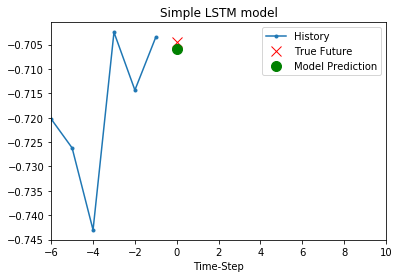

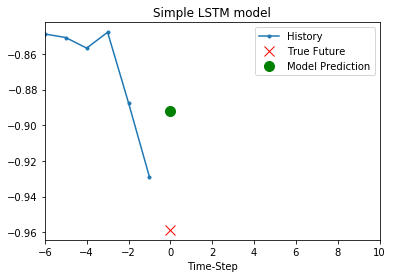

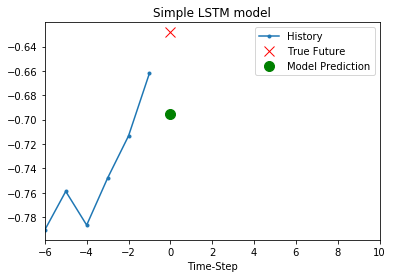

In [0]:
for x, y in dataVal.take(3):
  plot = show_plot([x[0].numpy(), y[0].numpy(),
                    simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
  plot.show()

def create_time_steps(length):
  return list(range(-length, 0))

def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt